# Ontology-based Semantic Similarity Measures for Clustering Medical Concepts in Drug Safety

Authors: 
  - François Haguinet <francois.f.haguinet@gsk.com>
  - Jeffery Painter <jeffery.l.painter@gsk.com>

Last updated:

  - 2025-Apr-11


## Background

This notebook explores the manually reviewed inclusion and exclusion of MedDRA codes
for SMQs where the SMQ name is represented by a PT of the same name.

Here, we explore the various semantic similarity metrics and performance
of each in support of later experiments in Bayesian borrowing.

All of the data and code necessary to regenerate the figures in the manuscript:

can be found below.

## Semantic Networks

The semantic similarities were generated using our websim tool, using a variety of ontological representations including:
 - MedDRA alone
 - MedDRA combined with Snomed-CT
 - MedDRA combined with MeSH
 - MedDRA combined with Snomed-CT and MeSH

Metrics considered include:
 - LCH
 - INTRINSIC_LCH
 - INTRINSIC_LIN
 - INTRINSIC_RESNIK
 - SOKAL
 - WUPALMER

In [1]:
#
# Python Libraries Required
#
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.copy_on_write = True

In [2]:
#
# List of Narrowly defined SMQs where the SMQ name contains
# a PT with the same name
#
# List of SMQs to consider in the loop
smq_def_file = "./data/smq_definition.csv"
smq_pts = pd.read_csv(smq_def_file, quotechar='"', delimiter = ",", escapechar="\\", on_bad_lines="skip" )

In [3]:
# keep only SMQs which include one PT with same label
selsmq = smq_pts.dropna()
# Exclude SMQs centroids without autolistedness
selsmq2 = selsmq[~selsmq["label"].isin(["Chronic kidney disease","COVID-19","Pulmonary hypertension"])]
listsmq = selsmq2["SMQ Code"].tolist()
print("List of SMQs")
print(listsmq)

#
# List of centroid PTs
#
selsmq2["PT_CODE"]=selsmq2["PT_CODE"].astype(int)
listpt = selsmq2["PT_CODE"].tolist()
print("List of centroid PTs")
print(listpt)

List of SMQs
[20000217, 20000073, 20000047, 20000045, 20000004, 20000222, 20000238, 20000150, 20000042, 20000024, 20000154, 20000146]
List of centroid PTs
[10028533, 10012267, 10028596, 10042945, 10007554, 10038695, 10040477, 10007636, 10022611, 10002424, 10012305, 10018304]


In [4]:
#
# The final, adjudicated, review of the MedDRA PT codes for SSM inclusion
# collected from our PV experts
#
allcntrssm = pd.DataFrame()
for cntrpt in listpt:
    fpath = "./data/adjudicated_results/" + str(cntrpt) + "_final.csv"
    print("Loading: " + fpath)
    centroid_ssm_df = pd.read_csv(fpath, quotechar='"', delimiter = ",", escapechar="\\", on_bad_lines="skip" )
    
    if allcntrssm.empty:
        allcntrssm = centroid_ssm_df
    else:
        allcntrssm = pd.concat([allcntrssm,centroid_ssm_df], ignore_index=True, axis=0)

Loading: ./data/adjudicated_results/10028533_final.csv
Loading: ./data/adjudicated_results/10012267_final.csv
Loading: ./data/adjudicated_results/10028596_final.csv
Loading: ./data/adjudicated_results/10042945_final.csv
Loading: ./data/adjudicated_results/10007554_final.csv
Loading: ./data/adjudicated_results/10038695_final.csv
Loading: ./data/adjudicated_results/10040477_final.csv
Loading: ./data/adjudicated_results/10007636_final.csv
Loading: ./data/adjudicated_results/10022611_final.csv
Loading: ./data/adjudicated_results/10002424_final.csv
Loading: ./data/adjudicated_results/10012305_final.csv
Loading: ./data/adjudicated_results/10018304_final.csv


## Descriptive analyses of reference sets

### Overall agreement between medical review and each reference set

In [5]:

xtable = pd.crosstab(allcntrssm['AUTOLIST'],allcntrssm['INCLUDE'])
print('Autolistedness vs Medical review')
print(xtable)
kappa = cohen_kappa_score(allcntrssm['AUTOLIST'],allcntrssm['INCLUDE'])
print("Cohen's Kappa: ", kappa)

xtable = pd.crosstab(allcntrssm['HLGT'],allcntrssm['INCLUDE'])
print('\nHLGT vs Medical review')
print(xtable)
kappa = cohen_kappa_score(allcntrssm['HLGT'],allcntrssm['INCLUDE'])
print("Cohen's Kappa: ", kappa)

xtable = pd.crosstab(allcntrssm['SMQ_CODE'],allcntrssm['INCLUDE'])
print('\nSMQ vs Medical review')
print(xtable)
kappa = cohen_kappa_score(allcntrssm['SMQ_CODE'],allcntrssm['INCLUDE'])
print("Cohen's Kappa: ", kappa)


Autolistedness vs Medical review
INCLUDE      0    1
AUTOLIST           
0         5779  437
1           48   83
Cohen's Kappa:  0.22958977710048678

HLGT vs Medical review
INCLUDE     0    1
HLGT              
0        5480  326
1         347  194
Cohen's Kappa:  0.3078648120635298

SMQ vs Medical review
INCLUDE      0    1
SMQ_CODE           
0         5623  292
1          204  228
Cohen's Kappa:  0.4371400005435303


### Agreements at centroid PT level

In [6]:
# List of centroid PTs
centrlis = allcntrssm['TERM_1'].unique().tolist()
reflist =['AUTOLIST','HLGT','SMQ_CODE']

revxref = pd.DataFrame()
strtctrl = pd.DataFrame({'POS_CTRL': [0, 1]})
for centri in centrlis:
    for refi in reflist:
        
        revsubin = allcntrssm[((allcntrssm['TERM_1'] == centri) & (allcntrssm['INCLUDE'] == 1))]
        counts = revsubin[refi].value_counts()
        cntrevin = counts.reset_index()
        cntrevin.columns = ['POS_CTRL', 'REVIEW_1']
        revsubout = allcntrssm[((allcntrssm['TERM_1'] == centri) & (allcntrssm['INCLUDE'] == 0))]
        counts = revsubout[refi].value_counts()
        cntrevout = counts.reset_index()
        cntrevout.columns = ['POS_CTRL', 'REVIEW_0']
        cntrevout=pd.merge(strtctrl,cntrevout, how="left", on=['POS_CTRL'])
        cntrevcnt=pd.merge(cntrevout, cntrevin, how="left", on=['POS_CTRL'])
        cntrevcnt.fillna(0, inplace=True)
        revsubk=allcntrssm[(allcntrssm['TERM_1'] == centri)]
        kappa=cohen_kappa_score(revsubk[refi],revsubk['INCLUDE'])
        cntrevcnt['kappa']=kappa
        cntrevcnt['Reference']=refi
        cntrevcnt['TERM_1'] = centri        
        if revxref.empty:
           revxref = cntrevcnt
        else:
            revxref = pd.concat([revxref,cntrevcnt], ignore_index=True, axis=0)

# Manuscript Figure 3

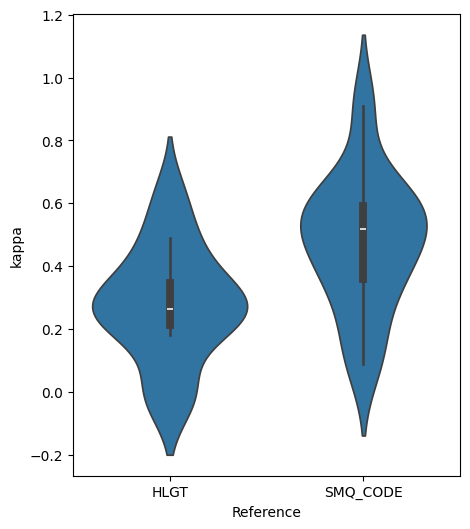

In [7]:

# Distribution of agreement between the different reference sets

krevxref = revxref[['kappa','Reference','TERM_1']]
krevxref = krevxref[krevxref['Reference'] != 'AUTOLIST']

plt.figure(figsize=(5,6))
sns.violinplot(x='Reference', y='kappa', data=krevxref)

plt.savefig('./figures/fig_03.png', dpi=300)
plt.show()



## Descriptive analyses of SSMs

Not included in the manuscript

### Histograms of SSMs within the selected SMQ centroid PTs and medically reviewed PTs

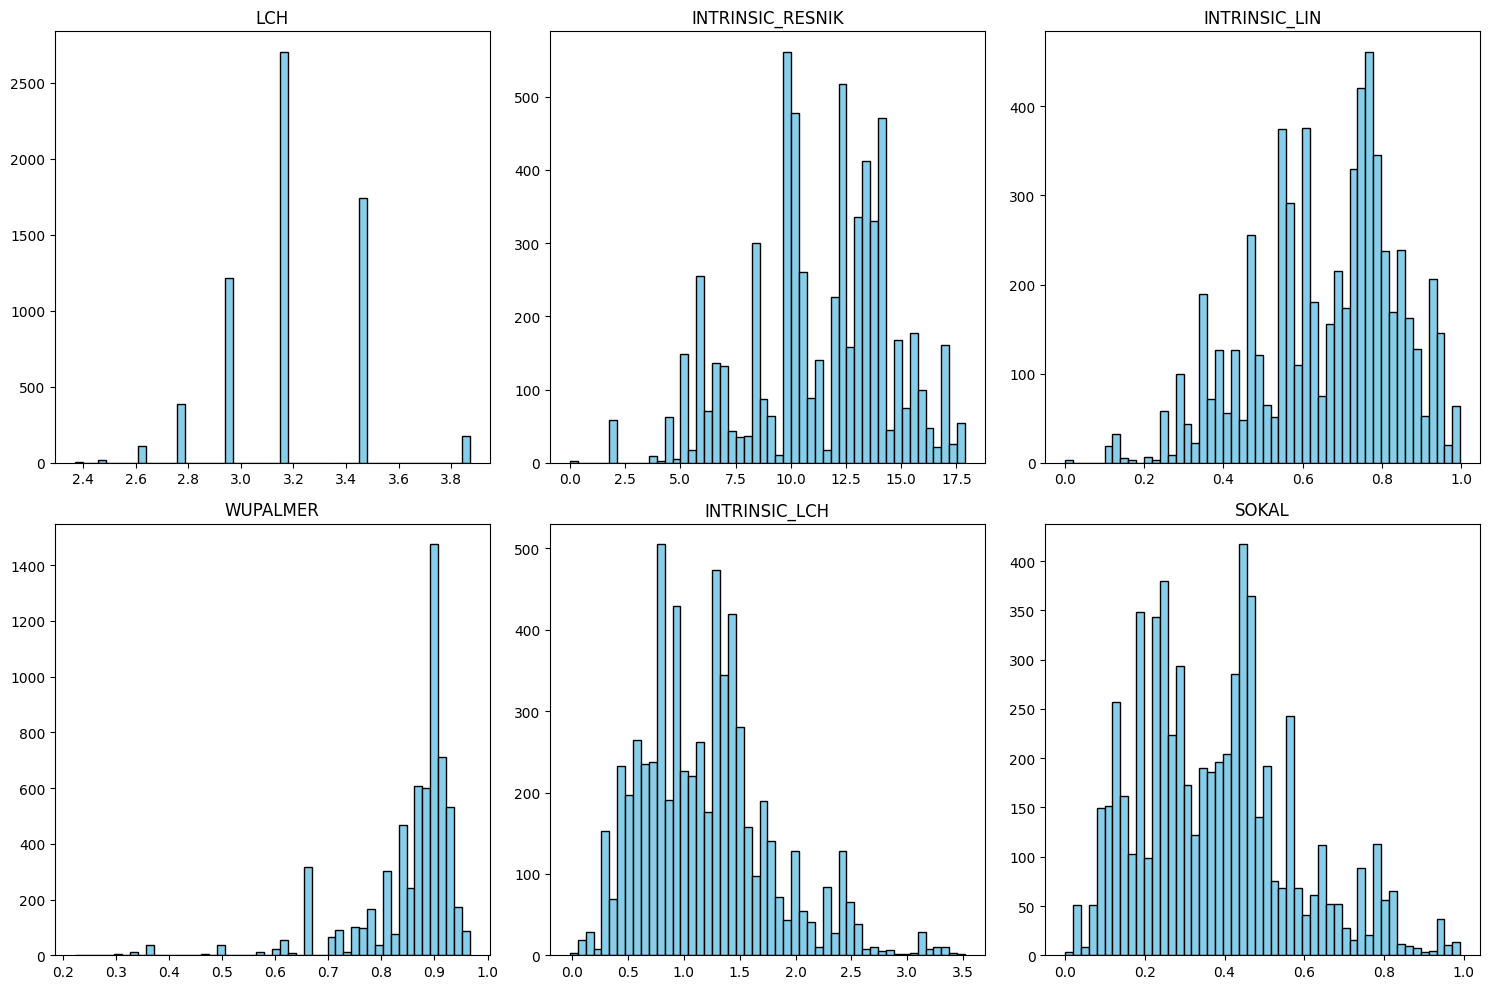

In [8]:
ssmlist = ['LCH','INTRINSIC_RESNIK','INTRINSIC_LIN','WUPALMER','INTRINSIC_LCH','SOKAL']

fig, axs = plt.subplots(2, 3, figsize=(15,10))

for i, col in enumerate(ssmlist):
    row = i // 3
    col = i % 3
    axs[row, col].hist(allcntrssm[ssmlist[i]], bins=50, color='skyblue', edgecolor='black')
    axs[row, col].set_title(ssmlist[i])

plt.tight_layout()
plt.show()

In [9]:
# Check number of unique SSM_val values by ontology and SSM across SMQs
distinct_counts = allcntrssm.nunique()
print("Distinct values of each SSM across centroid PTs")
print(distinct_counts)


Distinct values of each SSM across centroid PTs
PT_CODE_1             12
CUI_1                 12
TERM_1                12
TTY_1                  1
PT_CODE_2           4522
CUI_2               4413
TERM_2              4522
TTY_2                  1
INTRINSIC_LCH       3889
LCH                    8
WUPALMER              98
WUPALMER_PERL        459
SOKAL               3873
INTRINSIC_LIN       3881
INTRINSIC_RESNIK     195
NATURE_NORM         3868
MAX_METRIC             1
AUTOLIST               2
SMQ_CODE               2
HLT                    2
HLGT                   2
IN_SNOMED              2
INCLUDE                2
POSCTRL                2
dtype: int64


In [10]:
# Summary statistics of SSMs
selected_columns = allcntrssm[ssmlist]
summary_statistics = selected_columns.describe()
print(summary_statistics)


               LCH  INTRINSIC_RESNIK  INTRINSIC_LIN     WUPALMER  \
count  6347.000000       6347.000000    6347.000000  6347.000000   
mean      3.196931         11.329042       0.660096     0.853566   
std       0.248786          3.208423       0.181531     0.093068   
min       2.367124          0.000000       0.000000     0.222222   
25%       2.954910          9.703863       0.554207     0.833333   
50%       3.178054         12.019469       0.695264     0.888889   
75%       3.465736         13.639319       0.783927     0.904762   
max       3.871201         17.888155       0.997776     0.966667   

       INTRINSIC_LCH        SOKAL  
count    6347.000000  6347.000000  
mean        1.197905     0.376399  
std         0.575677     0.193485  
min        -0.020276     0.000000  
25%         0.760675     0.237106  
50%         1.166686     0.363212  
75%         1.484819     0.475621  
max         3.517105     0.991163  


In [11]:
# Rescaling of SSMs between 0 and 1
scaler = MinMaxScaler()
allcntrssm[ssmlist] = scaler.fit_transform(allcntrssm[ssmlist])


After rescaling


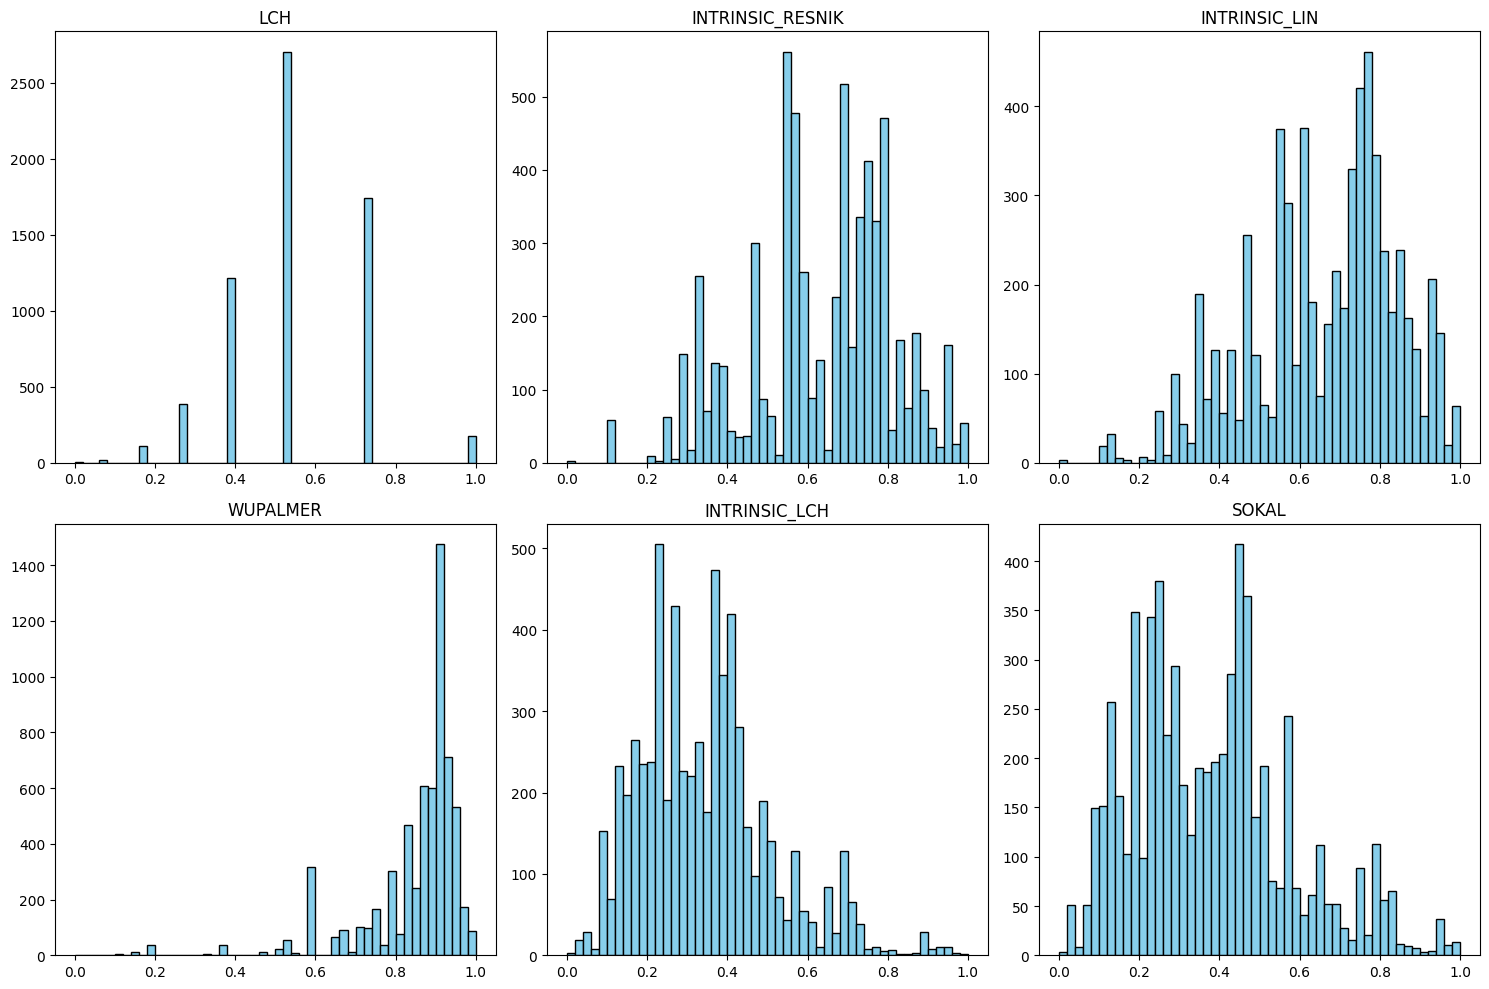

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))

for i, col in enumerate(ssmlist):
    row = i // 3
    col = i % 3
    axs[row, col].hist(allcntrssm[ssmlist[i]], bins=50, color='skyblue', edgecolor='black')
    axs[row, col].set_title(ssmlist[i])
print("After rescaling")
plt.tight_layout()
plt.show()

Rescaled SSMs
               LCH  INTRINSIC_RESNIK  INTRINSIC_LIN     WUPALMER  \
count  6347.000000       6347.000000    6347.000000  6347.000000   
mean      0.551705          0.633326       0.661567     0.848073   
std       0.165407          0.179360       0.181935     0.125017   
min       0.000000          0.000000       0.000000     0.000000   
25%       0.390795          0.542474       0.555442     0.820895   
50%       0.539155          0.671923       0.696814     0.895522   
75%       0.730423          0.762478       0.785674     0.916844   
max       1.000000          1.000000       1.000000     1.000000   

       INTRINSIC_LCH        SOKAL  
count    6347.000000  6347.000000  
mean        0.344374     0.379755  
std         0.162741     0.195210  
min         0.000000     0.000000  
25%         0.220771     0.239220  
50%         0.335548     0.366450  
75%         0.425483     0.479861  
max         1.000000     1.000000  


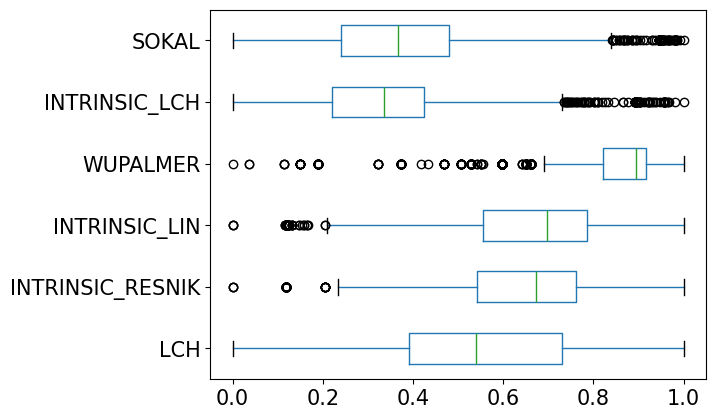

In [13]:
# Summary statistics of SSMs
print ('Rescaled SSMs')
selected_columns = allcntrssm[ssmlist]
summary_statistics = selected_columns.describe()
print(summary_statistics)
selected_columns = allcntrssm[ssmlist]
boxplot = selected_columns.boxplot(grid=False, vert=False,fontsize=15)
plt.show()

# Manuscript Figure 4(a)

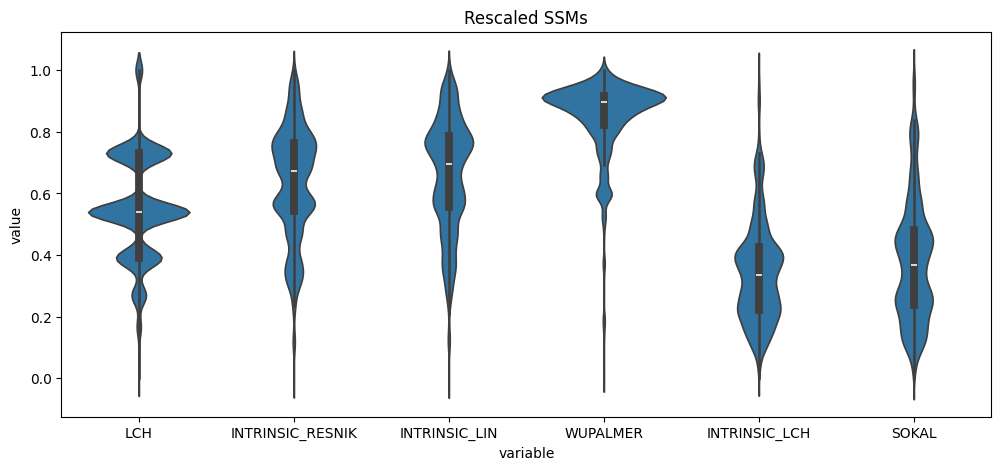

In [14]:
selected_columns = allcntrssm[ssmlist]
melted_df = pd.melt(selected_columns)

plt.figure(figsize=(12, 5))
# Create a violinplot for the selected columns
sns.violinplot(x='variable', y='value', data=melted_df)
plt.title('Rescaled SSMs')
plt.savefig('./figures/fig_04_a.png', dpi=300)
plt.show()

# Manuscript Figure 4(b)

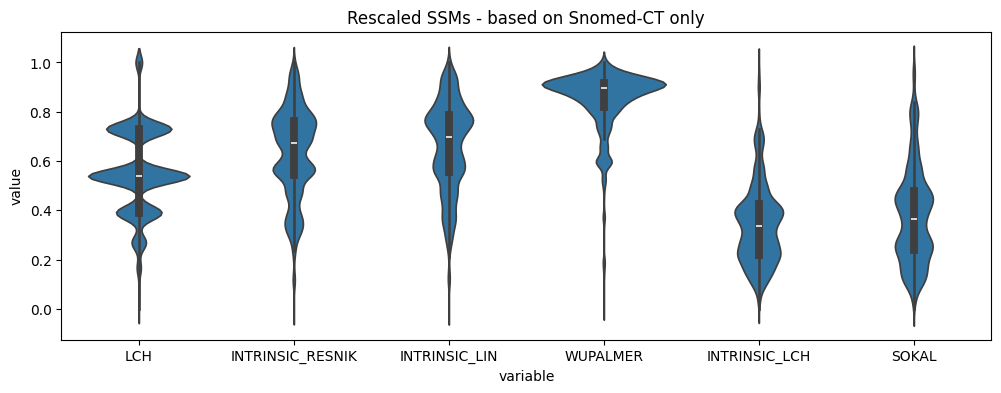

In [15]:
selected_columns = allcntrssm[ssmlist]
melted_df = pd.melt(selected_columns)

plt.figure(figsize=(12, 4))
# Create a violinplot for the selected columns
sns.violinplot(x='variable', y='value', data=melted_df)
plt.title('Rescaled SSMs - based on Snomed-CT only')
plt.savefig('./figures/fig_04_b.png', dpi=300)
plt.show()

# Manuscript Figure 4(c)

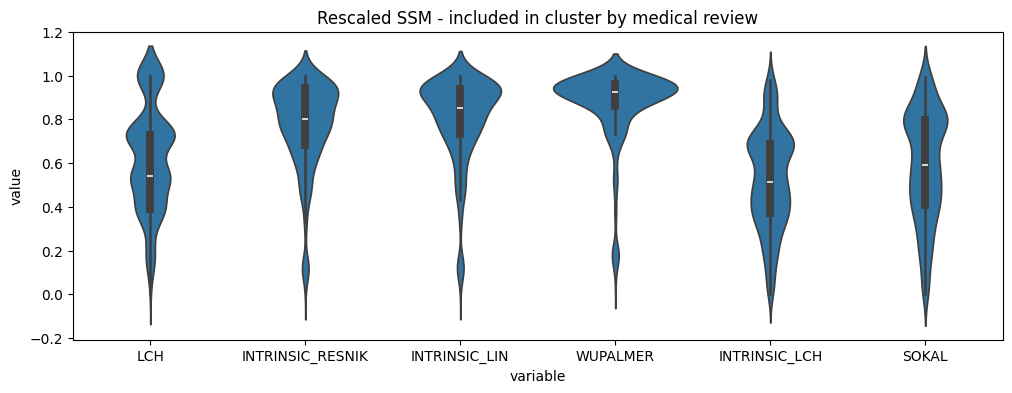

In [16]:
subinviolin = allcntrssm[allcntrssm['INCLUDE']==1]

plt.figure(figsize=(12, 4))
selected_columns = subinviolin[ssmlist]
melted_df = pd.melt(selected_columns)
# Create a violinplot for the selected columns
sns.violinplot(x='variable', y='value', data=melted_df)
plt.title('Rescaled SSM - included in cluster by medical review')
plt.savefig('./figures/fig_04_c.png', dpi=300)
plt.show()

# Manuscript Figure 5(a-d)

In [17]:
#
# Performance computation by descending SSM value
#
allcntrssm.rename(columns={'SMQ_CODE': 'IN_SMQ'}, inplace=True)

def perfssm(ssm, refset,outplt = True):
    perfallcentroid = allcntrssm
    # Total by centroid PT
    counts = perfallcentroid['TERM_1'].value_counts()
    perfallcentroid['TotalByCentroid'] = perfallcentroid['TERM_1'].map(counts)
    # Total of true positives 
    sums = perfallcentroid.groupby(['TERM_1'])[refset].transform('sum')
    perfallcentroid['TPsByCentroid'] = sums
    # Total of positives by SSM value
    counts = perfallcentroid.groupby(['TERM_1', ssm]).size()
    counts_df = counts.reset_index(name='RowsBySSM')
    perfallcentroid = pd.merge(perfallcentroid, counts_df, on=['TERM_1', ssm], how='left')
    # Total of true positives by SSM value
    sums = perfallcentroid.groupby(['TERM_1', ssm])[refset].transform('sum')
    perfallcentroid['TPsBySSM'] = sums
    #print(len(perfallcentroid))
    # Keep only one row by centroid PT (=TERM_1) and
    centroidssm = perfallcentroid.drop_duplicates(subset=['PT_CODE_1', 'TERM_1', ssm, 'TotalByCentroid', 'TPsByCentroid', 'RowsBySSM', 'TPsBySSM'])
    #print(len(centroidssm))
    centroidssm = centroidssm[['PT_CODE_1', 'TERM_1', ssm, 'TotalByCentroid','TPsByCentroid', 'RowsBySSM', 'TPsBySSM']]
    
    # Total of positive controls and negative controls by 
    centroidssm = centroidssm.sort_values(['TERM_1', ssm], ascending=[True, False])
    centroidssm['CumPOS'] = centroidssm.groupby('TERM_1')['RowsBySSM'].cumsum()
    centroidssm['CumTP'] = centroidssm.groupby('TERM_1')['TPsBySSM'].cumsum()
    centroidssm['CumFP'] = centroidssm['CumPOS'] - centroidssm['CumTP']
    centroidssm['CumTN'] = (centroidssm['TotalByCentroid'] - centroidssm['TPsByCentroid']) - centroidssm['CumFP']
    centroidssm['CumFN'] = centroidssm['TPsByCentroid'] - centroidssm['CumTP']
    centroidssm['Se'] = centroidssm['CumTP'] / (centroidssm['CumTP'] + centroidssm['CumFN'])
    centroidssm['PPV'] = centroidssm['CumTP'] / (centroidssm['CumTP'] + centroidssm['CumFP'])
    centroidssm['Sp'] = centroidssm['CumTN'] / (centroidssm['CumTN'] + centroidssm['CumFP'])
    centroidssm['FPR'] = 1 - centroidssm['Sp']
    centroidssm['F1'] = 2 * centroidssm['PPV'] * centroidssm['Se'] / (centroidssm['PPV'] + centroidssm['Se'])
    centroidssm['Accuracy'] = (centroidssm['CumTP'] + centroidssm['CumTN']) / centroidssm['TotalByCentroid']
  
    return centroidssm


In [18]:
#
# Mean curves across centroid PTs
#
referset = 'INCLUDE'
ssmlist = ['LCH','INTRINSIC_LCH','INTRINSIC_LIN','INTRINSIC_RESNIK','SOKAL','WUPALMER']

rawcntrssm = pd.DataFrame()
for ssmi in ssmlist:
    centroidssm = perfssm(ssmi, referset, False)
    centroidssm['SSM']=ssmi
    centroidssm['REFSET']=referset
    centroidssm.rename(columns={ssmi: 'SSM_VAL'}, inplace=True)
    if rawcntrssm.empty:
        rawcntrssm = centroidssm
    else:
        rawcntrssm = pd.concat([rawcntrssm,centroidssm], ignore_index=True, axis=0)

# Starting performance, when only the centroid PT is included in the cluster
startperf = rawcntrssm[['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid']].drop_duplicates(subset=['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid'])
startperf['SSM_VAL'] = 999
startperf['CumPOS'] = 1
startperf['CumTP'] = 1
startperf['CumFP'] = 0
startperf['CumTN'] = (startperf['TotalByCentroid'] - startperf['TPsByCentroid']) - startperf['CumFP']
startperf['CumFN'] = startperf['TPsByCentroid'] - startperf['CumTP']
startperf['Se'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFN'])
startperf['PPV'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFP'])
startperf['Sp'] = startperf['CumTN'] / (startperf['CumTN'] + startperf['CumFP'])
startperf['FPR'] = 1 - startperf['Sp']
startperf['F1'] = 2 * startperf['PPV'] * startperf['Se'] / (startperf['PPV'] + startperf['Se'])
startperf['Accuracy'] = (startperf['CumTP'] + startperf['CumTN']) / startperf['TotalByCentroid']

perfint = pd.concat([rawcntrssm,startperf], ignore_index=True, axis=0)

# Distinct SSM_VAL by SSM and ONTOLOGY
ssmvallist = perfint[['REFSET','SSM','SSM_VAL']].drop_duplicates()

# Distinct centroid PTs
smqdist = perfint[['TERM_1']].drop_duplicates()
#print(smqdist)
# Cross merge with SMQs
ssmvallist['key'] = 1
print(len(ssmvallist))
smqdist['key'] = 1
print(len(smqdist))
smqssmval = pd.merge(ssmvallist, smqdist, on ='key')
print(len(smqssmval))

clusinsel=pd.merge(smqssmval, perfint, how="left", on=['TERM_1','REFSET','SSM','SSM_VAL'])
print(len(clusinsel))
#clusinsely

clusvalsort = clusinsel.sort_values(['TERM_1','REFSET','SSM','SSM_VAL'],ascending=False)

# Impute LOCF
clusimpute=clusvalsort.ffill()
clusimpute

# Mean across centroid PTs
ssmmean = clusimpute[['REFSET','SSM','SSM_VAL','Se','Sp','FPR','PPV','F1','Accuracy']].groupby(['REFSET','SSM','SSM_VAL']).mean()
ssmmean = ssmmean.reset_index()
#print(ssmmean)

# ROC Curves by SSM
groups = ssmmean['SSM'].unique()



11950
12
143400
143400


## Manuscript Figure 5(a)

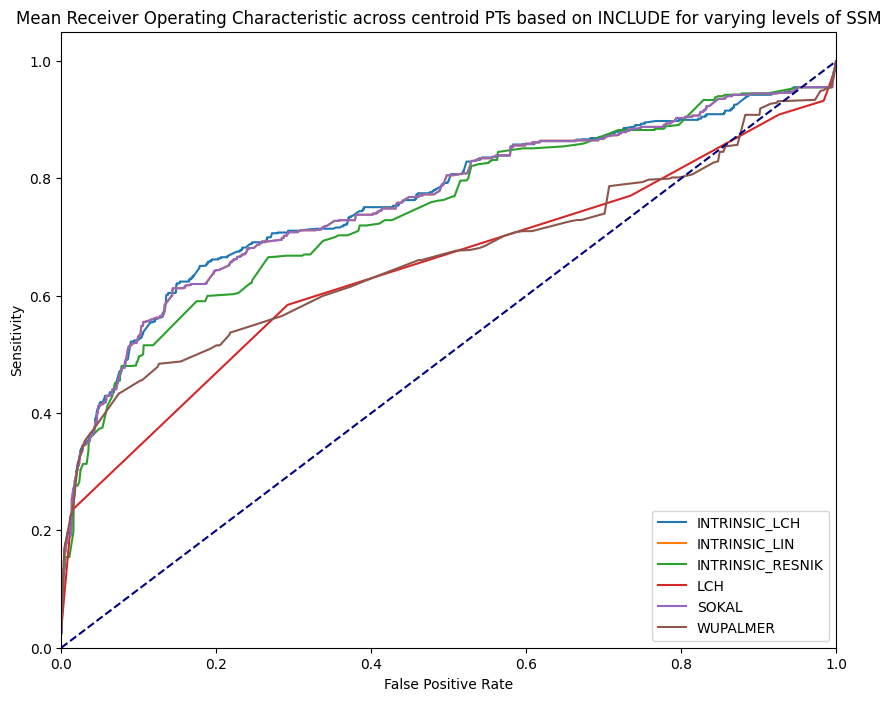

In [19]:

plt.figure(figsize=(10, 8))

for group in groups:
    data = ssmmean[ssmmean['SSM'] == group]
    plt.plot(data['FPR'], data['Se'], label=f'{group}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('Mean Receiver Operating Characteristic across centroid PTs based on '+ referset + ' for varying levels of SSM')
plt.legend(loc="lower right")
plt.savefig('./figures/fig_05_a.png', dpi=300)
plt.show()


## Manuscript Figure 5(b)

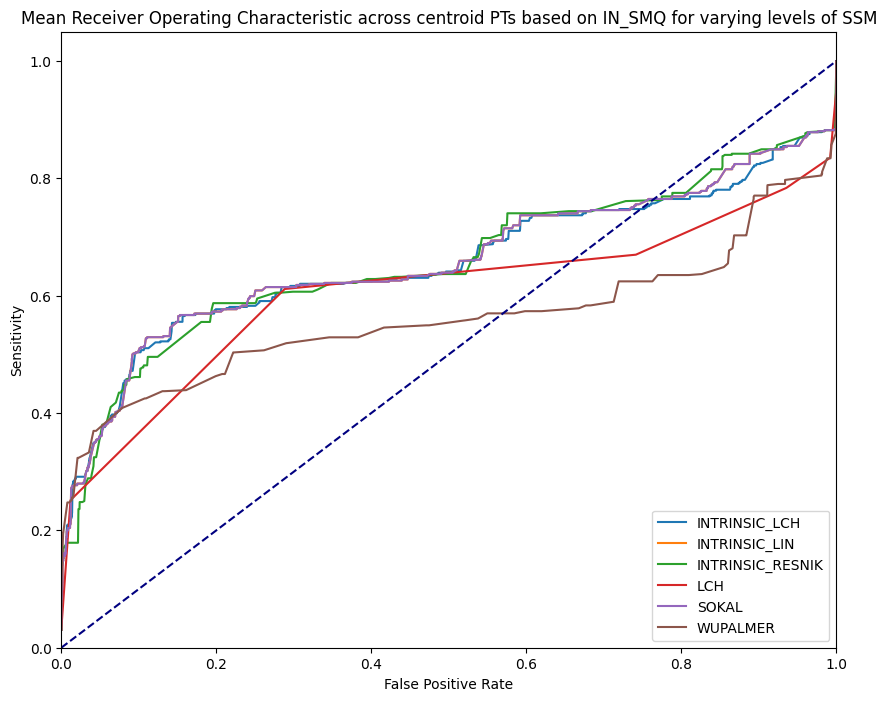

In [20]:
#
# Mean curves across centroid PTs
#
referset = 'IN_SMQ'
ssmlist = ['LCH','INTRINSIC_LCH','INTRINSIC_LIN','INTRINSIC_RESNIK','SOKAL','WUPALMER']

rawcntrssm = pd.DataFrame()
for ssmi in ssmlist:
    centroidssm = perfssm(ssmi, referset, False)
    centroidssm['SSM']=ssmi
    centroidssm['REFSET']=referset
    centroidssm.rename(columns={ssmi: 'SSM_VAL'}, inplace=True)
    if rawcntrssm.empty:
        rawcntrssm = centroidssm
    else:
        rawcntrssm = pd.concat([rawcntrssm,centroidssm], ignore_index=True, axis=0)

# Starting performance, when only the centroid PT is included in the cluster
startperf = rawcntrssm[['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid']].drop_duplicates(subset=['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid'])
startperf['SSM_VAL'] = 999
startperf['CumPOS'] = 1
startperf['CumTP'] = 1
startperf['CumFP'] = 0
startperf['CumTN'] = (startperf['TotalByCentroid'] - startperf['TPsByCentroid']) - startperf['CumFP']
startperf['CumFN'] = startperf['TPsByCentroid'] - startperf['CumTP']
startperf['Se'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFN'])
startperf['PPV'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFP'])
startperf['Sp'] = startperf['CumTN'] / (startperf['CumTN'] + startperf['CumFP'])
startperf['FPR'] = 1 - startperf['Sp']
startperf['F1'] = 2 * startperf['PPV'] * startperf['Se'] / (startperf['PPV'] + startperf['Se'])
startperf['Accuracy'] = (startperf['CumTP'] + startperf['CumTN']) / startperf['TotalByCentroid']

perfint = pd.concat([rawcntrssm,startperf], ignore_index=True, axis=0)

# Distinct SSM_VAL by SSM and ONTOLOGY
ssmvallist = perfint[['REFSET','SSM','SSM_VAL']].drop_duplicates()

# Distinct centroid PTs
smqdist = perfint[['TERM_1']].drop_duplicates()
#print(smqdist)
# Cross merge with SMQs
ssmvallist['key'] = 1
#print(len(ssmvallist))
smqdist['key'] = 1
#print(len(smqdist))
smqssmval = pd.merge(ssmvallist, smqdist, on ='key')
#print(len(smqssmval))

clusinsel=pd.merge(smqssmval, perfint, how="left", on=['TERM_1','REFSET','SSM','SSM_VAL'])
#print(len(clusinsel))
#clusinsely

clusvalsort = clusinsel.sort_values(['TERM_1','REFSET','SSM','SSM_VAL'],ascending=False)

# Impute LOCF
clusimpute=clusvalsort.ffill()
clusimpute

# Mean across centroid PTs
ssmmean = clusimpute[['REFSET','SSM','SSM_VAL','Se','Sp','FPR','PPV','F1','Accuracy']].groupby(['REFSET','SSM','SSM_VAL']).mean()
ssmmean = ssmmean.reset_index()
#print(ssmmean)

# ROC Curves by SSM
groups = ssmmean['SSM'].unique()

plt.figure(figsize=(10, 8))

for group in groups:
    data = ssmmean[ssmmean['SSM'] == group]
    plt.plot(data['FPR'], data['Se'], label=f'{group}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('Mean Receiver Operating Characteristic across centroid PTs based on '+ referset + ' for varying levels of SSM')
plt.legend(loc="lower right")
plt.savefig('./figures/fig_05_b.png', dpi=300)
plt.show()


## Manuscript Figure 5(c)

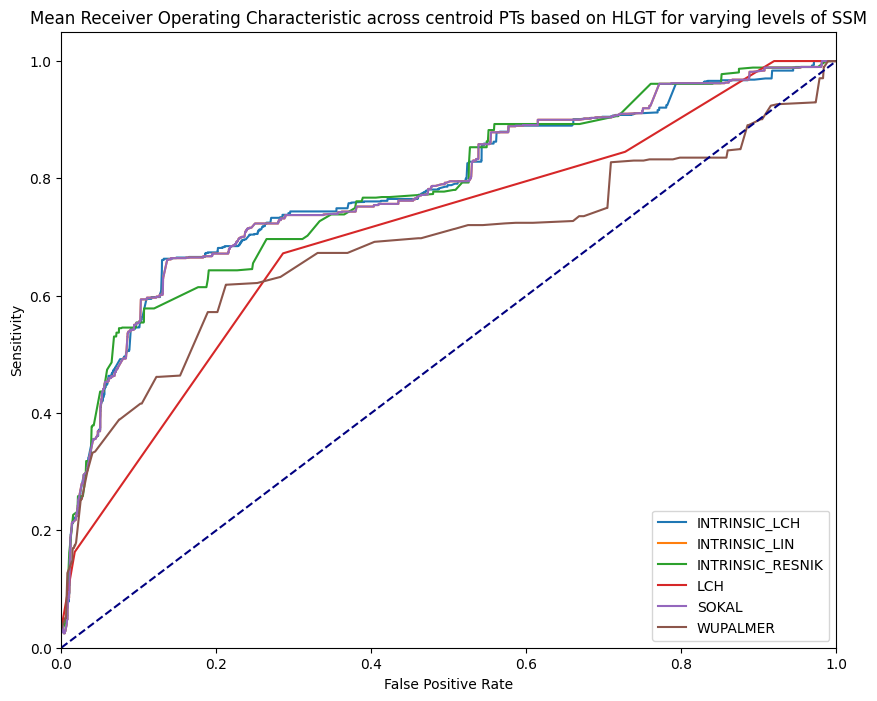

In [21]:
#
# Mean curves across centroid PTs
#

referset = 'HLGT'
ssmlist = ['LCH','INTRINSIC_LCH','INTRINSIC_LIN','INTRINSIC_RESNIK','SOKAL','WUPALMER']

rawcntrssm = pd.DataFrame()
for ssmi in ssmlist:
    centroidssm = perfssm(ssmi, referset, False)
    centroidssm['SSM']=ssmi
    centroidssm['REFSET']=referset
    centroidssm.rename(columns={ssmi: 'SSM_VAL'}, inplace=True)
    if rawcntrssm.empty:
        rawcntrssm = centroidssm
    else:
        rawcntrssm = pd.concat([rawcntrssm,centroidssm], ignore_index=True, axis=0)

# Starting performance, when only the centroid PT is included in the cluster
startperf = rawcntrssm[['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid']].drop_duplicates(subset=['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid'])
startperf['SSM_VAL'] = 999
startperf['CumPOS'] = 1
startperf['CumTP'] = 1
startperf['CumFP'] = 0
startperf['CumTN'] = (startperf['TotalByCentroid'] - startperf['TPsByCentroid']) - startperf['CumFP']
startperf['CumFN'] = startperf['TPsByCentroid'] - startperf['CumTP']
startperf['Se'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFN'])
startperf['PPV'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFP'])
startperf['Sp'] = startperf['CumTN'] / (startperf['CumTN'] + startperf['CumFP'])
startperf['FPR'] = 1 - startperf['Sp']
startperf['F1'] = 2 * startperf['PPV'] * startperf['Se'] / (startperf['PPV'] + startperf['Se'])
startperf['Accuracy'] = (startperf['CumTP'] + startperf['CumTN']) / startperf['TotalByCentroid']

perfint = pd.concat([rawcntrssm,startperf], ignore_index=True, axis=0)

# Distinct SSM_VAL by SSM and ONTOLOGY
ssmvallist = perfint[['REFSET','SSM','SSM_VAL']].drop_duplicates()

# Distinct centroid PTs
smqdist = perfint[['TERM_1']].drop_duplicates()
#print(smqdist)
# Cross merge with SMQs
ssmvallist['key'] = 1
#print(len(ssmvallist))
smqdist['key'] = 1
#print(len(smqdist))
smqssmval = pd.merge(ssmvallist, smqdist, on ='key')
#print(len(smqssmval))

clusinsel=pd.merge(smqssmval, perfint, how="left", on=['TERM_1','REFSET','SSM','SSM_VAL'])
#print(len(clusinsel))
#clusinsely

clusvalsort = clusinsel.sort_values(['TERM_1','REFSET','SSM','SSM_VAL'],ascending=False)

# Impute LOCF
clusimpute=clusvalsort.ffill()
clusimpute

# Mean across centroid PTs
ssmmean = clusimpute[['REFSET','SSM','SSM_VAL','Se','Sp','FPR','PPV','F1','Accuracy']].groupby(['REFSET','SSM','SSM_VAL']).mean()
ssmmean = ssmmean.reset_index()
#print(ssmmean)

# ROC Curves by SSM
groups = ssmmean['SSM'].unique()

plt.figure(figsize=(10, 8))

for group in groups:
    data = ssmmean[ssmmean['SSM'] == group]
    plt.plot(data['FPR'], data['Se'], label=f'{group}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('Mean Receiver Operating Characteristic across centroid PTs based on '+ referset + ' for varying levels of SSM')
plt.legend(loc="lower right")
plt.savefig('./figures/fig_05_c.png', dpi=300)
plt.show()



## Manuscript Figure 5(d)

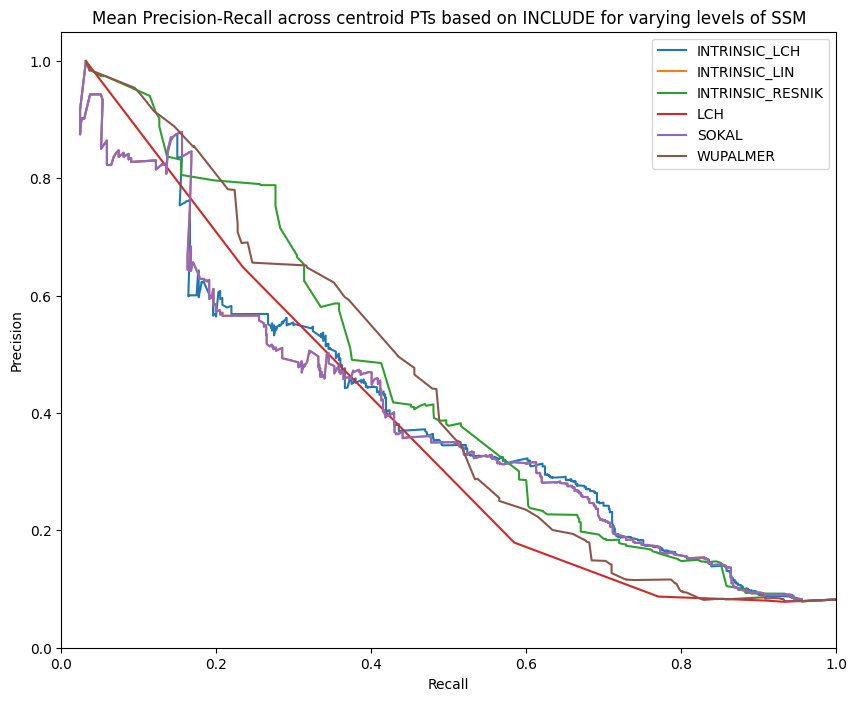

In [22]:
#
# Mean curves across centroid PTs
#

referset = 'INCLUDE'
ssmlist = ['LCH','INTRINSIC_LCH','INTRINSIC_LIN','INTRINSIC_RESNIK','SOKAL','WUPALMER']

rawcntrssm = pd.DataFrame()
for ssmi in ssmlist:
    centroidssm = perfssm(ssmi, referset, False)
    centroidssm['SSM']=ssmi
    centroidssm['REFSET']=referset
    centroidssm.rename(columns={ssmi: 'SSM_VAL'}, inplace=True)
    if rawcntrssm.empty:
        rawcntrssm = centroidssm
    else:
        rawcntrssm = pd.concat([rawcntrssm,centroidssm], ignore_index=True, axis=0)

# Starting performance, when only the centroid PT is included in the cluster
startperf = rawcntrssm[['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid']].drop_duplicates(subset=['TERM_1','SSM','REFSET','TotalByCentroid','TPsByCentroid'])
startperf['SSM_VAL'] = 999
startperf['CumPOS'] = 1
startperf['CumTP'] = 1
startperf['CumFP'] = 0
startperf['CumTN'] = (startperf['TotalByCentroid'] - startperf['TPsByCentroid']) - startperf['CumFP']
startperf['CumFN'] = startperf['TPsByCentroid'] - startperf['CumTP']
startperf['Se'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFN'])
startperf['PPV'] = startperf['CumTP'] / (startperf['CumTP'] + startperf['CumFP'])
startperf['Sp'] = startperf['CumTN'] / (startperf['CumTN'] + startperf['CumFP'])
startperf['FPR'] = 1 - startperf['Sp']
startperf['F1'] = 2 * startperf['PPV'] * startperf['Se'] / (startperf['PPV'] + startperf['Se'])
startperf['Accuracy'] = (startperf['CumTP'] + startperf['CumTN']) / startperf['TotalByCentroid']

perfint = pd.concat([rawcntrssm,startperf], ignore_index=True, axis=0)

# Distinct SSM_VAL by SSM and ONTOLOGY
ssmvallist = perfint[['REFSET','SSM','SSM_VAL']].drop_duplicates()

# Distinct centroid PTs
smqdist = perfint[['TERM_1']].drop_duplicates()
#print(smqdist)
# Cross merge with SMQs
ssmvallist['key'] = 1
#print(len(ssmvallist))
smqdist['key'] = 1
#print(len(smqdist))
smqssmval = pd.merge(ssmvallist, smqdist, on ='key')
#print(len(smqssmval))

clusinsel=pd.merge(smqssmval, perfint, how="left", on=['TERM_1','REFSET','SSM','SSM_VAL'])
#print(len(clusinsel))
#clusinsely

clusvalsort = clusinsel.sort_values(['TERM_1','REFSET','SSM','SSM_VAL'],ascending=False)

# Impute LOCF
clusimpute=clusvalsort.ffill()
clusimpute

# Mean across centroid PTs
ssmmean = clusimpute[['REFSET','SSM','SSM_VAL','Se','Sp','FPR','PPV','F1','Accuracy']].groupby(['REFSET','SSM','SSM_VAL']).mean()
ssmmean = ssmmean.reset_index()
#print(ssmmean)

# ROC Curves by SSM
groups = ssmmean['SSM'].unique()

# Precision-Recall curves by centroid PT
plt.figure(figsize=(10, 8))

for group in groups:
    data = ssmmean[ssmmean['SSM'] == group]
    plt.plot(data['Se'], data['PPV'], label=f'{group}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall across centroid PTs based on '+ referset + ' for varying levels of SSM')
plt.legend(loc="upper right")
plt.savefig('./figures/fig_05_d.png', dpi=300)
plt.show()


## Figure 6

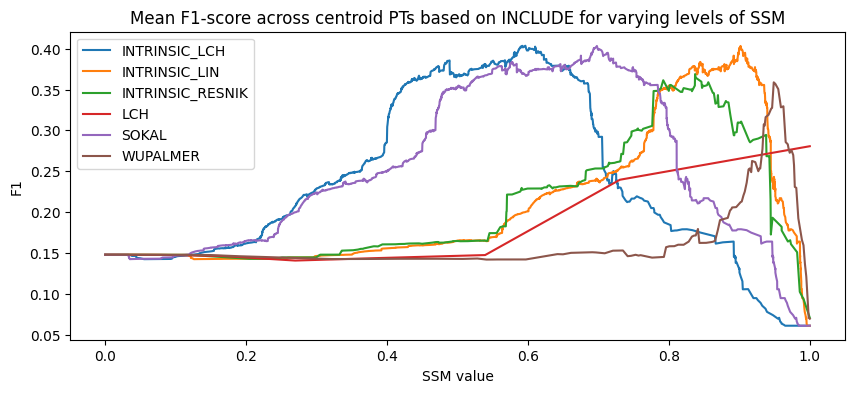

In [23]:
# F1 scores for varying SSM values by centroid PT
plt.figure(figsize=(10, 4))
plotbyssm = ssmmean[(ssmmean['SSM_VAL'] != 999)]
for group in groups:
    data = plotbyssm[plotbyssm['SSM'] == group]
    plt.plot(data['SSM_VAL'], data['F1'], label=f'{group}')

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('SSM value')
plt.ylabel('F1')
plt.title('Mean F1-score across centroid PTs based on '+ referset + ' for varying levels of SSM')
plt.legend(loc="upper left")
plt.savefig('./figures/fig_06.png', dpi=300)
plt.show()
